# SPECTRUM FITTING

The following codes approach the problem in 2 different ways. Scipy is used for continuum fitting, using a power law. 
Emission line fitting is performed using Gaussian (and trapezoid, if required) models in astropy. Both codes allow you to choose a range of wavelengths that you want to investigate (by changing 'lower_limit', and 'upper_limit').

You could no doubt flip this around, and perform either task using either python module, but I haven't had time to explore this further.

An alternative way of doing these fits may in fact to be to invoke R code... embedd in the Python code

These codes import a csv file into a pandas dataframe; could utilise astropy.io to import FITS files if required - can also convert into a dataframe if required.

## Scipy - Continuum Fit

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html for scipy.optimize.curve_fit details

Here I present a power law fit - can also perform polynomial fits using curve_fit.

Also see https://github.com/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb and https://arxiv.org/abs/1305.0215 for an alternative python powerlaw module, that could possibly automate the wavelength ranges fitted.

In [16]:
%matplotlib inline
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [17]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df1.head(2)

,wavelength,flux,model_top,model_middle,model_bottom,flux_minus_top,flux_minus_middle,flux_minus_bottom,Unnamed: 8,flux_minus_middle_minus20,flux_minus_top_minus15
0,1279,439.459226,452.737237,360.165597,393.085315,-13.278011,79.293629,46.373911,NaN,59.293629,-28.278011
1,1280,436.743732,452.094768,359.708749,392.566460,-15.351036,77.034983,44.177272,NaN,57.034983,-30.351036


Text(0,0.5,'Spectral Flux Density / AU')

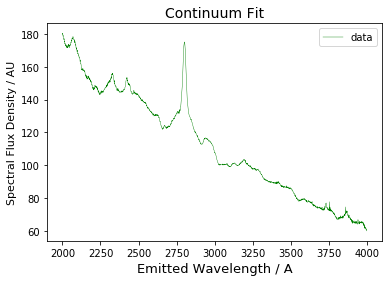

In [18]:
# choose the range of spectrum you want to apply the continuum fit to
lower_limit = 2000
upper_limit = 4000
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

# plot this section of spectrum (spectral flux density is in arbitrary units)
df2.plot(x='wavelength', y='flux', lw=0.4, color='green', label='data')
plt.title('Continuum Fit', fontsize=14, color='black')
plt.xlabel('Emitted Wavelength / A',  fontsize=13)
plt.ylabel('Spectral Flux Density / AU', fontsize=11)

In [19]:
xData = df2['wavelength']
yData = df2['flux']

def f(x, N, a):
    return N * x ** a

# optimize
popt, pcov = curve_fit(f, xData, yData)

# the output here are the values for k and a, respectively, where y = kx^a
popt[0], popt[1]

(4866879.7542540003, -1.3402994773264718)

In [20]:
# 1SD of the parameters in popt, calculated from the covariance pcov array
perr = np.sqrt(np.diag(pcov))
perr

array([  3.35403727e+05,   8.74178420e-03])

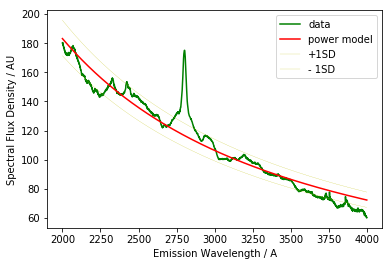

In [21]:
# plot data with power model
plt.plot(xData, yData, 'g', label='data') # original spectrum data in green
plt.plot(xData, popt[0]*xData**popt[1], 'r', label='power model') # power model data in red

# plot standard deviation curves, based on perr
plt.plot(xData, (popt[0]+perr[1])*xData**(popt[1]+perr[1]), lw=0.2, color='y', label='+1SD')
plt.plot(xData, (popt[0]-perr[1])*xData**(popt[1]-perr[1]), lw=0.2, color='y', label='- 1SD')

plt.xlabel('Emission Wavelength / A')
plt.ylabel('Spectral Flux Density / AU')
plt.legend()
plt.savefig(os.path.join(path, 'spectrum_continuum.png'), dpi = 1080)

## Astropy - Emission Line Fit

See http://docs.astropy.org/en/stable/modeling/index.html for astropy model details
This code works by inputting a csv file of data which has already had the baseline continuum model subtracted. You could also perform this subtraction easily within the pandas dataframe if so desired, and even input the power law model automatically from the Scipy code above if you were really clever. 

In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import os
from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D

In [23]:
# Using the Levenberg-Marquardt algorithm and least squares statistic - LevMarLSQFitter()
# Fitting Gaussian and Trapezoid models to a curve

In [24]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv' # wavelength 2670 - 2920 for emission line fitting - MgII
df1 = pd.read_csv(os.path.join(path, file))
df1.head(3)

,wavelength,flux,model_top,model_middle,model_bottom,flux_minus_top,flux_minus_middle,flux_minus_bottom,Unnamed: 8,flux_minus_middle_minus20,flux_minus_top_minus15
0,1279,439.459226,452.737237,360.165597,393.085315,-13.278011,79.293629,46.373911,NaN,59.293629,-28.278011
1,1280,436.743732,452.094768,359.708749,392.566460,-15.351036,77.034983,44.177272,NaN,57.034983,-30.351036
2,1281,362.859198,451.453711,359.252836,392.048693,-88.594512,3.606363,-29.189495,NaN,-16.393637,-103.594512


In [25]:
lower_limit = 4800
upper_limit = 4950
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

Text(0,0.5,'Continuum-Subtracted Spectral Flux Density / AU')

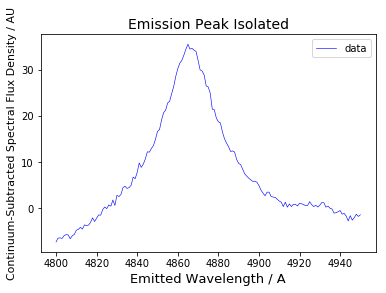

In [26]:
df2.plot(x='wavelength', y='flux_minus_top_minus15', lw=0.6, color='blue', label='data') #lw = line width
plt.title('Emission Peak Isolated', fontsize=14, color='black')
plt.legend()
# plt.grid(True)
plt.xlabel('Emitted Wavelength / A',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU', fontsize=11)

In [27]:
x = df2['wavelength']
y = df2['flux_minus_top_minus15']

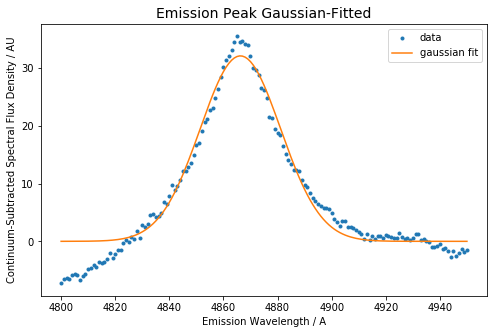

In [28]:
# Fit the data using a box model
# Insert best guesses for model parameters
#t_init = models.Trapezoid1D(amplitude=58, x_0=2797., width=200, slope=0.5)
#fit_t = fitting.LevMarLSQFitter()
#t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
# set mean as the rest emission wavelength for species (e.g. Mg II)
g_init = models.Gaussian1D(amplitude=40, mean=4861, stddev=25)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, '.', label='data')
#plt.plot(x, t(x), label='Trapezoid')
plt.title('Emission Peak Gaussian-Fitted', fontsize=14, color='black')
plt.plot(x, g(x), label='gaussian fit')
plt.xlabel('Emission Wavelength / A')
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU')
plt.legend()
plt.savefig(os.path.join(path, 'Hbeta_curve_fit.png'), dpi = 1080)

In [29]:
# this prints the model output parameters after fitting
print(g)
#Prints FWHM (units are Angstroms)...
g.fwhm

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    32.1075967968 4866.26363376 14.8723453122


35.021696857719952

In [30]:
# this prints the model output parameters after fitting
# print(t)